#### Задание 

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Задача:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.
8. Рекомендован Случайный лес

In [171]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier as RFR
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('DZ Feature Selection/data/aac_shelter_outcomes.csv')
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
# все столбцы данных не являются числовыми и требуют предобработки
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [5]:
# наибольшее число пропусков outcome_subtype - что это?
# похоже это то, что происходит после события, которое мы хотим предсказать, а поэтому спокойно удаляем
data.outcome_subtype.unique()

array(['Partner', nan, 'Rabies Risk', 'Suffering', 'Offsite', 'Foster',
       'SCRP', 'In Kennel', 'Aggressive', 'Medical', 'Behavior', 'At Vet',
       'In Foster', 'Enroute', 'In Surgery', 'Possible Theft',
       'Court/Investigation', 'Barn', 'Snr', 'Underage'], dtype=object)

In [6]:
data = data.drop('outcome_subtype', axis=1)

In [7]:
# также много пропусков у имени, его бы стоило удалить, но судя по тому, что большинство данных аккуратно заполнены, наверное наличие имени значимо
data['name'] = data[['name']].fillna(value = 0) 
data['has_name'] = (data['name']!= 0).astype ('int64') 
data = data.drop('name', axis = 1)

In [8]:
# age_upon_outcome, sex_upon_outcome имеют небольшое число пропусков
# заменим на наиболее частые
data = data.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [9]:
# столбы datetime, monthyear дублируют друг друга, к тому данные age_upon_outcome явно будут коррелировать с date_of_birth и datetime
# можно удалить эти столбцы, они не добавляют нам информации
# лучше, наверное, оставить дату события, нежели дату рождения, которая с меньшей вероятностью с событием связана 
data = data.drop('date_of_birth', axis = 1)
data = data.drop('monthyear', axis = 1)

In [10]:
# осталось убрать столбец, который навряд ли понадобятся
data = data.drop('animal_id', axis = 1)

In [11]:
# из столбцов, которые могут быть полезны, столбцы: breed, color, datetime имеют большое количество уникальных значений. 
# с ними сложнее, чем с другими
data.nunique()

age_upon_outcome       46
animal_type             5
breed                2128
color                 525
datetime            64361
outcome_type            9
sex_upon_outcome        5
has_name                2
dtype: int64

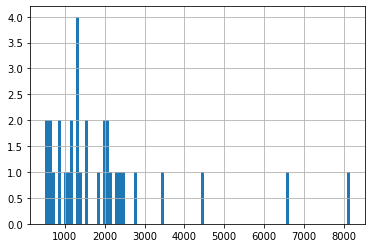

In [12]:
n_colors = data['color'].value_counts()
n_colors[n_colors > 500].hist(bins=100)

In [13]:
# заменим значения colors встречающиеся менее 500 раз, на others
color_others = set(n_colors[n_colors < 500].index)
data['top_colors'] = data['color'].replace(list(color_others), 'others')
data['top_colors'].nunique()

33

In [14]:
# выделим свойство смешанной окраски
data['multi_colors'] = data['color'].apply(lambda x : 1 if '/' in x else 0)

In [15]:
# пород множество, но может быть полезно свойство Mix
data.breed.value_counts()

Domestic Shorthair Mix                            23335
Pit Bull Mix                                       6135
Chihuahua Shorthair Mix                            4733
Labrador Retriever Mix                             4608
Domestic Medium Hair Mix                           2323
                                                  ...  
Rat Terrier/Queensland Heeler                         1
American Sable Mix                                    1
Australian Cattle Dog/Treeing Walker Coonhound        1
Dachshund Wirehair/Yorkshire Terrier                  1
Frog                                                  1
Name: breed, Length: 2128, dtype: int64

In [16]:
import re
data['breed_type'] = data.breed.str.extract('({})'.format('|'.join(['mix'])), 
                                              flags=re.IGNORECASE, expand=False).str.lower().fillna('mono')

In [18]:
# заменим значения age_upon_outcome на число дней
def age_converter(row):
    age_string = row['age_upon_outcome']
    [age, unit] = age_string.split(" ")
    unit = unit.lower()
    if("day" in unit):
        if age=='0': return 1
        return int(age)
    if("week" in unit):
        if(age)=='0': return 7
        return int(age)*7
    elif("month" in unit):
        if(age)=='0': return 30
        return int(age) * 4*7
    elif("year" in unit):
        if(age)=='0': return 365
        return int(age) * 4*12*7
    
data['age_numeric'] = data.apply(age_converter, axis=1)

In [21]:
data.rename(columns={'datetime': 'date_time'}, inplace=True)

In [38]:
# выделим в отдельные столбцы год и месяц, это может быть связано с событием
from datetime import datetime, date, time
import maya

def year(row):

    dt = maya.parse(row['date_time']).datetime()
    t = dt.isocalendar()[0] 
    
    return t

def month(row):

    dt = maya.parse(row['date_time']).datetime()
    t = dt.isocalendar()[2]
    
    return t

data['month'] = data.apply(month, axis=1)
data['year'] = data.apply(year, axis=1)

In [41]:
data = data.drop(['breed','color', 'date_time', 'age_upon_outcome'], axis=1)

In [45]:
# применим pandas get_dummies для преобразования всех категориальных переменных в отдельные столбцы

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).drop(['outcome_type'], axis=1).columns

dummy_columns = pd.get_dummies(data[categorical_features])

final_data = pd.concat([dummy_columns, data],axis=1)
final_data = final_data.drop(['animal_type', 'breed_type', 'sex_upon_outcome', 'top_colors'], axis=1)

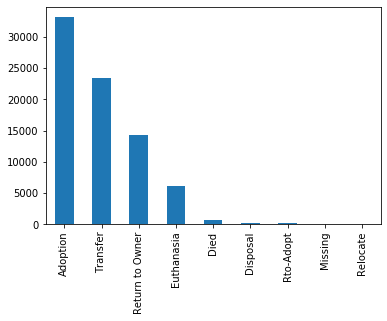

In [46]:
# умерших и эвтаназии намного меньше, чем другие - может оказаться трудным предсказать эти результаты
# заменим все результаты, кроме Adoption и Transfer на others
data['outcome_type'].value_counts().plot.bar()

In [51]:
n_target = final_data['outcome_type'].value_counts()
target_others = set(n_target[n_target < 15000].index)
final_data['target'] = final_data['outcome_type'].replace(list(target_others), 'others')
final_data['target'].nunique()

3

In [53]:
final_data = final_data.drop('outcome_type', axis = 1)
final_data.head()

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,top_colors_Yellow,top_colors_others,breed_type_mix,breed_type_mono,has_name,multi_colors,age_numeric,year,month,target
0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,14,2014,2,Transfer
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,1,336,2013,4,Transfer
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,1,1,336,2014,2,Adoption
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,3024,2014,7,Transfer
4,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,140,2014,1,others


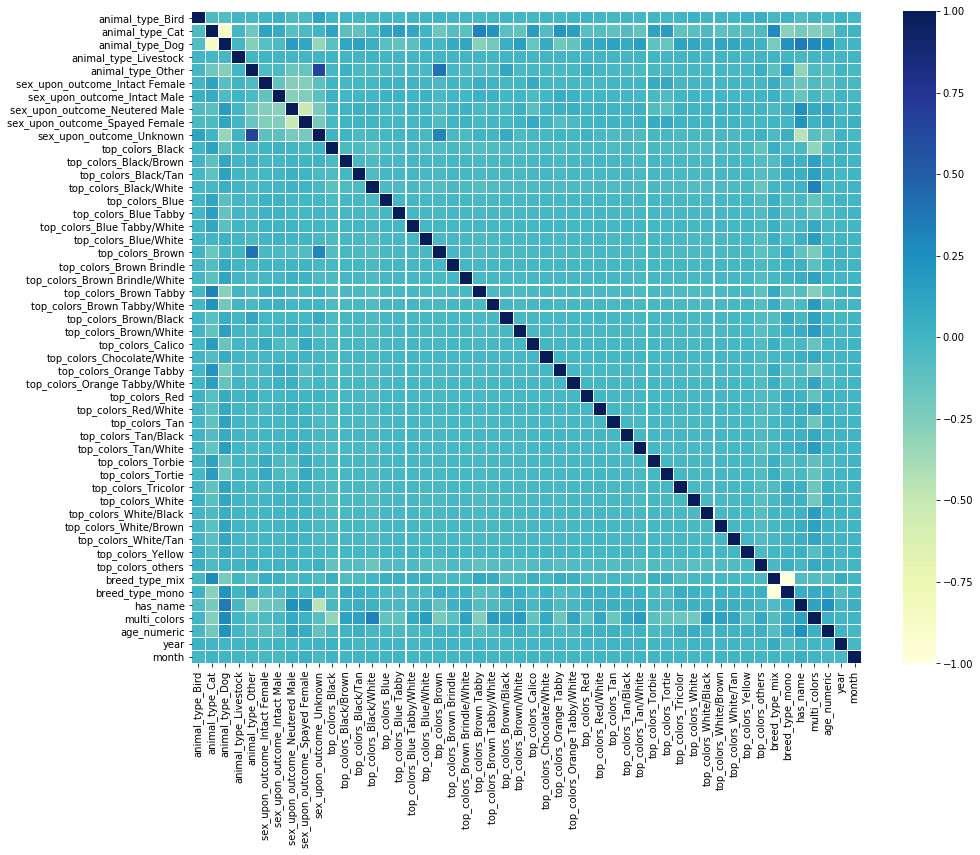

In [63]:
# наблюдаем корреляцию параметров окраски и породы у кошек и собак, а также у неизвестных животных с неизвестным sex_upon_outcome
# пока оставим как есть
corrmat = final_data.corr()

f, ax = plt.subplots(figsize =(15, 12))

sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [65]:
# посмотрим выбросы у параметров с числовыми значениями
numeric_features

Index(['has_name', 'multi_colors', 'age_numeric', 'year', 'month'], dtype='object')

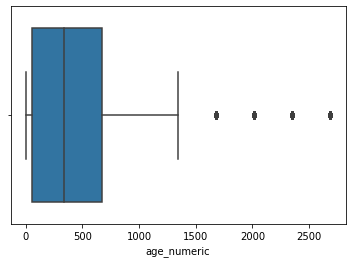

In [74]:
sns.boxplot(final_data[final_data['age_numeric'] < 3000]['age_numeric'])

In [84]:
# оставим данные больше 14 и меньше 4000
final_data = final_data[final_data['age_numeric'] < 4000]
final_data = final_data[final_data['age_numeric'] > 14]
final_data.age_numeric.value_counts()

336     14363
672     11194
56       9213
1008     5157
28       4538
84       3442
1344     2990
1680     2691
112      2425
140      1951
168      1897
2016     1810
2688     1554
2352     1537
21       1467
280      1204
224      1178
3360     1159
196       963
3024      822
252       673
308       490
3696      429
365        95
35         61
Name: age_numeric, dtype: int64

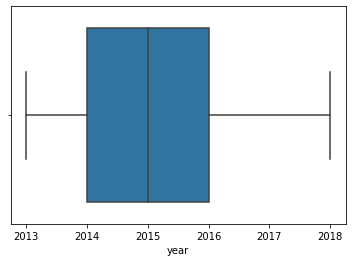

In [88]:
sns.boxplot(final_data['year'])

In [93]:
final_data.year.value_counts()

2014    17494
2015    17403
2017    16622
2016    16386
Name: year, dtype: int64

In [92]:
# исключим значения 2013 и 2018 года - этих значений сравнительно мало
final_data = final_data[(final_data['year'] != 2013) & (final_data['year'] != 2018)]

In [94]:
final_data.month.value_counts()

6    11003
7    10596
2     9915
1     9727
5     9080
3     8916
4     8668
Name: month, dtype: int64

In [96]:
final_data.head()

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,top_colors_Yellow,top_colors_others,breed_type_mix,breed_type_mono,has_name,multi_colors,age_numeric,year,month,target
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,1,1,336,2014,2,Adoption
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,3024,2014,7,Transfer
4,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,140,2014,1,others
6,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,336,2014,6,others
7,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1008,2014,1,Transfer


In [120]:
#y = final_data['target']
#X = final_data.drop('target', axis = 1)
y = proba_data['target']
X = proba_data.drop('target', axis = 1)

res = []

for d in [x for x in range(1, len(X.columns)+1)]:
    
    X2 = PCA(n_components=d).fit_transform(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3)
    
    model = RFR().fit(x_train, y_train)
    
    print(f'var = {d}, score = {model.score(x_test, y_test)}')
    res.append(model.score(x_test, y_test))

var = 1, score = 0.5645493815040251
var = 2, score = 0.6266444139014333
var = 3, score = 0.6345474180247398
var = 4, score = 0.6360691144708424
var = 5, score = 0.6534949931278226
var = 6, score = 0.6531022972707637
var = 7, score = 0.6542312978598076
var = 8, score = 0.6481935990575299
var = 9, score = 0.6506479481641468
var = 10, score = 0.6435794227370901
var = 11, score = 0.6476045552719418
var = 12, score = 0.6489789907716473
var = 13, score = 0.6506970351462792
var = 14, score = 0.6505988611820145
var = 15, score = 0.6544767327704692
var = 16, score = 0.6495189475751031
var = 17, score = 0.6511879049676026


In [121]:
# максимальный результат с top_colors 0.6487335558609857 при var = 14
# максимальный результат без top_colors: 
max(res)

0.6544767327704692

In [113]:
top_colors = [w for w in final_data.columns if w.startswith("top_colors")]
top_colors

['top_colors_Black',
 'top_colors_Black/Brown',
 'top_colors_Black/Tan',
 'top_colors_Black/White',
 'top_colors_Blue',
 'top_colors_Blue Tabby',
 'top_colors_Blue Tabby/White',
 'top_colors_Blue/White',
 'top_colors_Brown',
 'top_colors_Brown Brindle',
 'top_colors_Brown Brindle/White',
 'top_colors_Brown Tabby',
 'top_colors_Brown Tabby/White',
 'top_colors_Brown/Black',
 'top_colors_Brown/White',
 'top_colors_Calico',
 'top_colors_Chocolate/White',
 'top_colors_Orange Tabby',
 'top_colors_Orange Tabby/White',
 'top_colors_Red',
 'top_colors_Red/White',
 'top_colors_Tan',
 'top_colors_Tan/Black',
 'top_colors_Tan/White',
 'top_colors_Torbie',
 'top_colors_Tortie',
 'top_colors_Tricolor',
 'top_colors_White',
 'top_colors_White/Black',
 'top_colors_White/Brown',
 'top_colors_White/Tan',
 'top_colors_Yellow',
 'top_colors_others']

In [119]:
# попробуем убрать top_colors и посмотреть как изменится результат
proba_data = final_data.drop(top_colors, axis = 1)
proba_data

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,breed_type_mix,breed_type_mono,has_name,multi_colors,age_numeric,year,month,target
2,0,0,1,0,0,0,0,1,0,0,0,1,1,1,336,2014,2,Adoption
3,0,0,1,0,0,0,0,1,0,0,1,0,1,0,3024,2014,7,Transfer
4,0,0,0,0,1,0,0,0,0,1,1,0,0,0,140,2014,1,others
6,0,0,0,0,1,0,0,0,0,1,1,0,0,0,336,2014,6,others
7,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1008,2014,1,Transfer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78225,0,0,1,0,0,0,0,1,0,0,1,0,1,0,672,2017,3,Adoption
78227,0,0,1,0,0,0,0,1,0,0,1,0,1,0,672,2017,7,Adoption
78231,0,1,0,0,0,1,0,0,0,0,1,0,1,1,56,2017,7,Adoption
78232,0,1,0,0,0,0,1,0,0,0,1,0,1,1,28,2017,7,Adoption


In [159]:
# оценим результат без применения PCA: отличается всего на 0.003

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
model = RFR().fit(x_train, y_train)
model.score(x_test, y_test)

0.6505006872177499

In [200]:
param = list(X.columns)
param

['animal_type_Bird',
 'animal_type_Cat',
 'animal_type_Dog',
 'animal_type_Livestock',
 'animal_type_Other',
 'sex_upon_outcome_Intact Female',
 'sex_upon_outcome_Intact Male',
 'sex_upon_outcome_Neutered Male',
 'sex_upon_outcome_Spayed Female',
 'sex_upon_outcome_Unknown',
 'breed_type_mix',
 'breed_type_mono',
 'has_name',
 'multi_colors',
 'age_numeric',
 'year',
 'month']

In [202]:
X[param]

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,breed_type_mix,breed_type_mono,has_name,multi_colors,age_numeric,year,month
2,0,0,1,0,0,0,0,1,0,0,0,1,1,1,336,2014,2
3,0,0,1,0,0,0,0,1,0,0,1,0,1,0,3024,2014,7
4,0,0,0,0,1,0,0,0,0,1,1,0,0,0,140,2014,1
6,0,0,0,0,1,0,0,0,0,1,1,0,0,0,336,2014,6
7,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1008,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78225,0,0,1,0,0,0,0,1,0,0,1,0,1,0,672,2017,3
78227,0,0,1,0,0,0,0,1,0,0,1,0,1,0,672,2017,7
78231,0,1,0,0,0,1,0,0,0,0,1,0,1,1,56,2017,7
78232,0,1,0,0,0,0,1,0,0,0,1,0,1,1,28,2017,7


In [205]:
# исключим параметры, после исключения которых результат улучшился
dict_param0 = {}
q = 0

for i in range(0, len(param)+1):
    
    param = list(X.columns)
    
    if i < len(param):
        del param[i]
    else:
        param = list(X.columns)
    
    XX = X[param]
    x_train, x_test, y_train, y_test = train_test_split(XX, y, test_size = 0.3)
        
    reg = RFR().fit(x_train, y_train)
    q = reg.score(x_test, y_test)
    
    dict_param0[str(param)] = q
        
dict_param0

{"['animal_type_Cat', 'animal_type_Dog', 'animal_type_Livestock', 'animal_type_Other', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown', 'breed_type_mix', 'breed_type_mono', 'has_name', 'multi_colors', 'age_numeric', 'year', 'month']": 0.6465737286471628,
 "['animal_type_Bird', 'animal_type_Dog', 'animal_type_Livestock', 'animal_type_Other', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown', 'breed_type_mix', 'breed_type_mono', 'has_name', 'multi_colors', 'age_numeric', 'year', 'month']": 0.6473591203612802,
 "['animal_type_Bird', 'animal_type_Cat', 'animal_type_Livestock', 'animal_type_Other', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown', 'breed_type_m

In [207]:
# такие параметры: 'year', 'month', 'multi_colors', 'breed_type_mix', 'breed_type_mono', 
# 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'animal_type_Other'
for keys in dict_param0:
    print(keys, dict_param0[keys], "-" ,dict_param[keys])

['animal_type_Cat', 'animal_type_Dog', 'animal_type_Livestock', 'animal_type_Other', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown', 'breed_type_mix', 'breed_type_mono', 'has_name', 'multi_colors', 'age_numeric', 'year', 'month'] 0.6465737286471628 - 0.6479972511290006
['animal_type_Bird', 'animal_type_Dog', 'animal_type_Livestock', 'animal_type_Other', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown', 'breed_type_mix', 'breed_type_mono', 'has_name', 'multi_colors', 'age_numeric', 'year', 'month'] 0.6473591203612802 - 0.6477518162183389
['animal_type_Bird', 'animal_type_Cat', 'animal_type_Livestock', 'animal_type_Other', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'sex_upon_o

In [209]:
param_del = ['year', 'month', 'multi_colors', 'breed_type_mix', 'breed_type_mono', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 'animal_type_Other']
X_del = X.drop(param_del, axis = 1)
X_del

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,has_name,age_numeric
2,0,0,1,0,1,0,0,1,336
3,0,0,1,0,1,0,0,1,3024
4,0,0,0,0,0,0,1,0,140
6,0,0,0,0,0,0,1,0,336
7,0,0,1,0,0,1,0,1,1008
...,...,...,...,...,...,...,...,...,...
78225,0,0,1,0,1,0,0,1,672
78227,0,0,1,0,1,0,0,1,672
78231,0,1,0,0,0,0,0,1,56
78232,0,1,0,0,0,0,0,1,28


In [210]:
# наилучшее сочетание выбранных параметров: 'animal_type_Cat', 'animal_type_Dog', 'animal_type_Livestock', 
# 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'has_name', 'age_numeric'
param = list(X_del.columns)

import itertools

dict_param = {}
maxim = 0
q = 0
nn = 0

for n in range(2, len(param)):
    
    print(n)
    
    for i in itertools.combinations(param, n):
        nn += 1
        
        XX = X_del[list(i)]
        x_train, x_test, y_train, y_test = train_test_split(XX, y, test_size = 0.3)
        
        reg = RFR().fit(x_train, y_train)
        q = reg.score(x_test, y_test)
        
        
        if q > maxim:
            dict_param[i] = q
            maxim = q
            print(nn, i, ":", maxim)
dict_param

2
1 ('animal_type_Bird', 'animal_type_Cat') : 0.4457097977616336
2 ('animal_type_Bird', 'animal_type_Dog') : 0.4474769291183978
3 ('animal_type_Bird', 'animal_type_Livestock') : 0.44860592970744156
5 ('animal_type_Bird', 'sex_upon_outcome_Spayed Female') : 0.4529255841350874
6 ('animal_type_Bird', 'sex_upon_outcome_Unknown') : 0.4987237384645592
7 ('animal_type_Bird', 'has_name') : 0.5017671313567642
8 ('animal_type_Bird', 'age_numeric') : 0.5078048301590419
14 ('animal_type_Cat', 'has_name') : 0.5268996662085215
15 ('animal_type_Cat', 'age_numeric') : 0.5422638916159435
21 ('animal_type_Dog', 'age_numeric') : 0.5426565874730022
27 ('sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female') : 0.5833496956607108
3
55 ('animal_type_Bird', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female') : 0.5839878264284312
76 ('animal_type_Cat', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female') : 0.6218338896524641
113 ('sex_upon_outcome_Neutered Male', 'sex

{('animal_type_Bird', 'animal_type_Cat'): 0.4457097977616336,
 ('animal_type_Bird', 'animal_type_Dog'): 0.4474769291183978,
 ('animal_type_Bird', 'animal_type_Livestock'): 0.44860592970744156,
 ('animal_type_Bird', 'sex_upon_outcome_Spayed Female'): 0.4529255841350874,
 ('animal_type_Bird', 'sex_upon_outcome_Unknown'): 0.4987237384645592,
 ('animal_type_Bird', 'has_name'): 0.5017671313567642,
 ('animal_type_Bird', 'age_numeric'): 0.5078048301590419,
 ('animal_type_Cat', 'has_name'): 0.5268996662085215,
 ('animal_type_Cat', 'age_numeric'): 0.5422638916159435,
 ('animal_type_Dog', 'age_numeric'): 0.5426565874730022,
 ('sex_upon_outcome_Neutered Male',
  'sex_upon_outcome_Spayed Female'): 0.5833496956607108,
 ('animal_type_Bird',
  'sex_upon_outcome_Neutered Male',
  'sex_upon_outcome_Spayed Female'): 0.5839878264284312,
 ('animal_type_Cat',
  'sex_upon_outcome_Neutered Male',
  'sex_upon_outcome_Spayed Female'): 0.6218338896524641,
 ('sex_upon_outcome_Neutered Male',
  'sex_upon_outcome_

In [179]:
#Посмотрим корреляцию параметров с target - нет корреляции, ничего не можем отобрать
le = preprocessing.LabelEncoder()
le.fit(y)

y_tr = le.transform(list(y))
y_tr = pd.Series(y_tr)

In [180]:
data_all = pd.concat([X, y_tr], axis=1)
data_all.corr()

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,breed_type_mix,breed_type_mono,has_name,multi_colors,age_numeric,year,month,0
animal_type_Bird,1.000000,-0.049532,-0.077961,-0.000673,-0.016251,-0.003481,0.046624,-0.050784,-0.046955,0.128975,-0.012546,0.012546,-0.065601,-0.006621,-0.021675,0.021212,-0.015341,-0.005603
animal_type_Cat,-0.049532,1.000000,-0.879034,-0.007588,-0.183241,0.117021,0.062491,-0.071086,-0.013331,-0.063105,0.277728,-0.277728,-0.181445,-0.259490,-0.216033,-0.000385,0.017837,0.001589
animal_type_Dog,-0.077961,-0.879034,1.000000,-0.011943,-0.288411,-0.090774,-0.047244,0.158640,0.095924,-0.307110,-0.212203,0.212203,0.341624,0.284060,0.248565,-0.003374,-0.004063,-0.002087
animal_type_Livestock,-0.000673,-0.007588,-0.011943,1.000000,-0.002490,0.005660,0.005415,-0.004775,-0.007193,0.008603,0.004472,-0.004472,-0.016204,-0.004998,-0.004621,-0.004291,-0.007452,0.005985
animal_type_Other,-0.016251,-0.183241,-0.288411,-0.002490,1.000000,-0.048190,-0.042299,-0.176399,-0.163314,0.748908,-0.119651,0.119651,-0.333289,-0.065985,-0.076069,0.002133,-0.023608,0.002448
sex_upon_outcome_Intact Female,-0.003481,0.117021,-0.090774,0.005660,-0.048190,1.000000,-0.127440,-0.270413,-0.250024,-0.096678,0.055091,-0.055091,-0.156701,-0.046654,-0.087048,-0.011620,-0.023049,-0.002904
sex_upon_outcome_Intact Male,0.046624,0.062491,-0.047244,0.005415,-0.042299,-0.127440,1.000000,-0.276680,-0.255819,-0.098919,0.030841,-0.030841,-0.129873,-0.009045,-0.076432,0.006094,-0.027934,-0.006268
sex_upon_outcome_Neutered Male,-0.050784,-0.071086,0.158640,-0.004775,-0.176399,-0.270413,-0.276680,1.000000,-0.542819,-0.209895,-0.029302,0.029302,0.220533,0.071305,0.102207,-0.001350,0.014597,0.003304
sex_upon_outcome_Spayed Female,-0.046955,-0.013331,0.095924,-0.007193,-0.163314,-0.250024,-0.255819,-0.542819,1.000000,-0.194069,0.013648,-0.013648,0.192529,0.009888,0.057917,0.008030,0.032548,0.001793
sex_upon_outcome_Unknown,0.128975,-0.063105,-0.307110,0.008603,0.748908,-0.096678,-0.098919,-0.209895,-0.194069,1.000000,-0.076261,0.076261,-0.418422,-0.084602,-0.097832,-0.005636,-0.024501,0.001834


In [181]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier()
clf_tree.fit(x_train, y_train)
clf_tree.score(x_test, y_test)
clf_tree.feature_importances_

array([0.0057352 , 0.03426039, 0.01525983, 0.        , 0.03974696,
       0.09097273, 0.10458468, 0.0119472 , 0.0126578 , 0.10556062,
       0.01609308, 0.01743105, 0.04676697, 0.0491017 , 0.25437411,
       0.071441  , 0.12406668])

([<matplotlib.axis.YTick at 0x7fee8403fb90>,
 <a list of 17 Text yticklabel objects>)

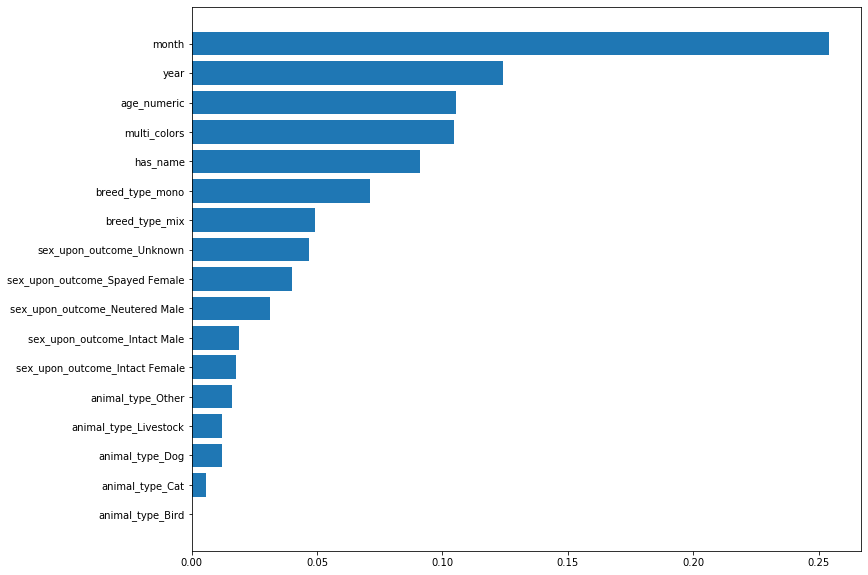

In [165]:
#Посмотрим важность признаков
plt.figure(figsize=(12,10))
plt.barh(np.arange(len(clf_tree.feature_importances_)), np.sort(clf_tree.feature_importances_))
plt.yticks(np.arange(len(X.columns)), X.columns)

#### Как видим выше, в числе важнейших признаков признаки, которые ухудшают результат

In [211]:
# снова попробуем PCA на лучшем сочетании параметров
best_param = ['animal_type_Cat', 'animal_type_Dog', 'animal_type_Livestock', 'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female', 'has_name', 'age_numeric']
XX = X_del[best_param]
res = []

for d in [x for x in range(1, len(XX.columns)+1)]:
    
    X2 = PCA(n_components=d).fit_transform(XX)
    
    x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3)
    
    model = RFR().fit(x_train, y_train)
    
    print(f'var = {d}, score = {model.score(x_test, y_test)}')
    res.append(model.score(x_test, y_test))

var = 1, score = 0.6564892990378951
var = 2, score = 0.6764186137836246
var = 3, score = 0.6730316120164932
var = 4, score = 0.6748969173375221
var = 5, score = 0.6788729628902415
var = 6, score = 0.6761240918908306
var = 7, score = 0.6725898291773021


### Как видим из эксперимента выше, 
### PCA ухудшает  ранее достигнутый результат c лучшими параметрами 
### PCA max = 0.6725898291773021 против 0.680983703121932 без PCA.